In [ ]:
import sys
print(sys.executable, sys.version)


/Users/uxb/miniforge3/envs/ptyroenv/bin/python 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:52:34) [Clang 18.1.8 ]


In [2]:
# disable JAX resize in helper & microscope
import ptyrodactyl.photons.helper    as _helper
import ptyrodactyl.photons.microscope as _microscope
_helper.scale_pixel      = lambda wf, dx_new: wf
_microscope.scale_pixel = lambda wf, dx_new: wf

# patch the CTF so it always matches field shape

import ptyrodactyl.photons.engine as _engine
_orig_get_ctf = _engine._get_ctf

def _dynamic_apply_ctf(field_ft):
   ctf = _orig_get_ctf(field_ft.shape)
   return ctf * field_ft


# override the engine’s apply-CTF
_engine._apply_coherent_transfer_function = _dynamic_apply_ctf

# imports
import jax, jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from ptyrodactyl.photons.microscope import simple_microscope
from ptyrodactyl.photons.engine     import epie_optical
from ptyrodactyl.photons.photon_types import (
   make_optical_wavefront,
   make_sample_function,
   MicroscopeData,
)


In [3]:
# build full 128x128 sample + 64×64 probe for the forward step
full_size = 128
dx        = 1e-6
x = jnp.linspace(-full_size//2*dx, full_size//2*dx, full_size)
X, Y = jnp.meshgrid(x, x)

# amplitude ripple + quadratic phase
ampl = 1.0 + 0.3*jnp.sin(2*jnp.pi*X/(20*dx))*jnp.cos(2*jnp.pi*Y/(30*dx))
phz  = jnp.exp(1j*(X**2+Y**2)/(2e-3))
obj  = ampl * phz
sample_fn = make_sample_function(sample=obj, dx=dx)

# small 64×64 Gaussian probe
small_N = 64
x_s     = jnp.linspace(-small_N//2, small_N//2-1, small_N)*dx
Xp, Yp  = jnp.meshgrid(x_s, x_s)
probe_amp = jnp.exp(-(Xp**2+Yp**2)/(2*(10e-6)**2))
probe = make_optical_wavefront(
    field      = probe_amp.astype(jnp.complex128),
    wavelength = 500e-9,
    dx         = dx,
    z_position = 0.0,
)

Measured ptychograms: (5, 64, 64)


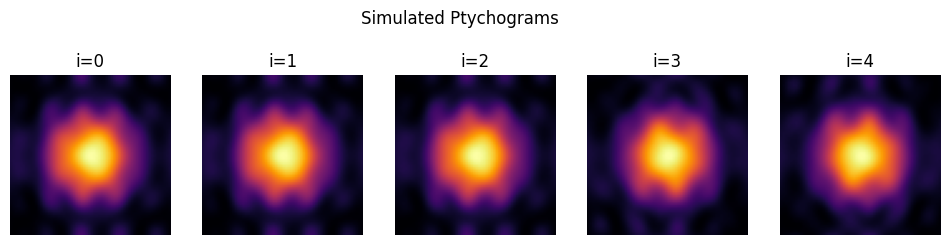

In [4]:
# generate 5 scan positions and forward simulated ptychograms

# five pixel shifts around center 
center_px = jnp.array([full_size//2, full_size//2])
shifts   = jnp.array([[ 0,0],[20,0],[-20,0],[0,20],[0,-20]])
positions = (center_px + shifts) * dx  # shape (5,2)

md: MicroscopeData = simple_microscope(
    sample            = sample_fn,
    positions         = positions,
    lightwave         = probe,
    zoom_factor       = 1.0,
    aperture_diameter = 1e-3,
    travel_distance   = 0.1,
    camera_pixel_size = dx,
)
print("Measured ptychograms:", md.image_data.shape)

# plot 
fig, axs = plt.subplots(1,5,figsize=(12,3))
for i, ax in enumerate(axs):
    ax.imshow(md.image_data[i], cmap="inferno")
    ax.set_title(f"i={i}")
    ax.axis("off")
plt.suptitle("Simulated Ptychograms"); plt.show()


In [ ]:
# prepare surface guess and sensor pixel mask
surface_fn = make_sample_function(
    sample = jnp.ones(probe.field.shape, dtype=jnp.complex128),
    dx     = dx,
)
pixel_mask = jnp.ones(probe.field.shape, dtype=jnp.float64)

# run ePIE
recovered_obj, recovered_surf = epie_optical(
    microscope_data        = md,
    initial_object         = probe,
    initial_surface        = surface_fn,
    pixel_mask             = pixel_mask,
    propagation_distance_1 = 0.0,
    propagation_distance_2 = 0.1,
    magnification          = 1,
    vmap_iterations        = 5,
    alpha_object           = 0.2,
    gamma_object           = 0.5,
    alpha_surface          = 0.2,
    gamma_surface          = 0.5,
    num_loops              = 20,
)



In [6]:
# pull out arrays for plotting
obj_field = recovered_obj.field   # complex field of the object
surf = recovered_surf.sample # complex field of the surface

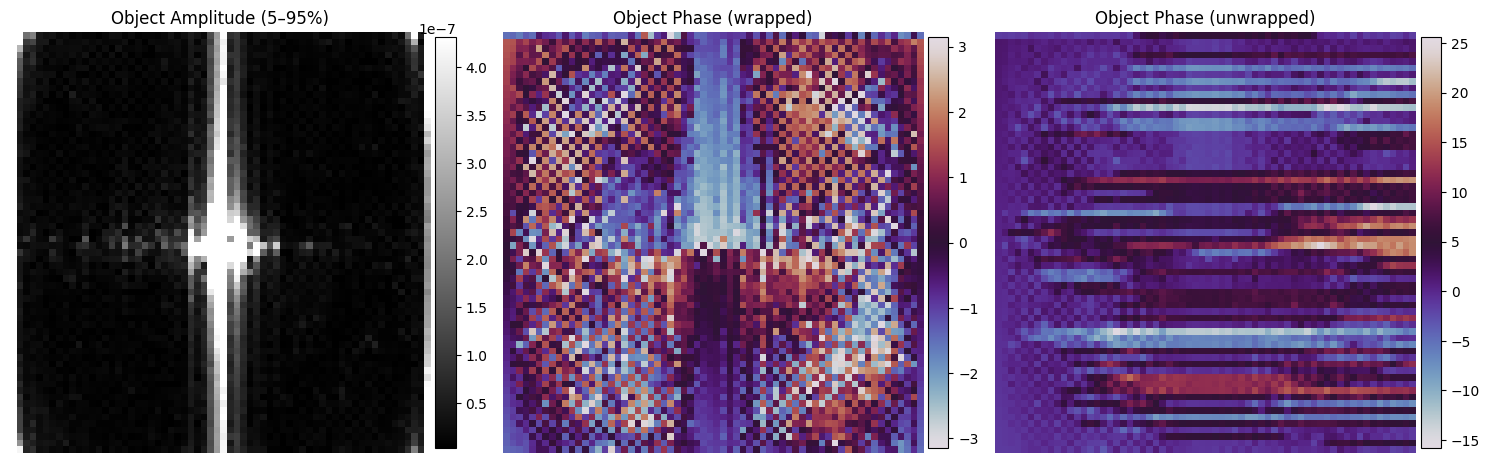

In [ ]:
# convert jax arrays to numpy
obj_amp   = np.abs(np.array(obj_field))
obj_phase = np.angle(np.array(obj_field))

# unwrapped phase in 2D (unwrap along rows then columns)
obj_phase_unwrapped = np.unwrap(np.unwrap(obj_phase, axis=0), axis=1)

# compute 5th and 95th percentiles for amplitude clipping (better visualization than full range)
vmin, vmax = np.percentile(obj_amp, [5, 95])

# figure creation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# amplitude clipped between 5% and 95%
im0 = axes[0].imshow(obj_amp, cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title("Object Amplitude (5–95%)")
axes[0].axis('off')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.01)

# wrapped phase
im1 = axes[1].imshow(obj_phase, cmap='twilight', vmin=-np.pi, vmax=np.pi)
axes[1].set_title("Object Phase (Wrapped)")
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.01)

# unwrapped phase
im2 = axes[2].imshow(obj_phase_unwrapped, cmap='twilight')
axes[2].set_title("Object Phase (Unwrapped)")
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.01)

plt.tight_layout()
plt.show()
